In [2]:
import pandas as pd
import numpy as np


import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn.manifold
import collections

from sklearn.decomposition import TruncatedSVD

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.svm import SVC

import joblib

import warnings
warnings.filterwarnings('ignore')

## 1. Загрузка очищенных данных

In [3]:
df = pd.read_csv('clean_min_docs.csv')

In [4]:
df

,Unnamed: 0,Unnamed: 0.1,label,url,text,len in symbols,len in words
0,0,0,0,http://arbitrsamara.ru/dogovor-arendy/obespech...,связь правило высокий стоимость имущество пере...,215,28
1,1,1,0,http://inlobnya.ru/novosti/obrazovanie/vospita...,быть правительство брать обязанность выплачива...,181,26
2,2,2,0,http://marslanov.com/otzyvy/audit-kompanii-22-...,затем потребоваться снять крупный сумма начать...,329,49
3,3,3,0,http://mail.mycompany.su/RU/dinskaya/company/m...,каждый фирма рубрика услуга микрофинансировани...,128,18
4,4,4,1,https://ok.ru/ksfirst/topic/70000727225755,минимальный пакет документ минимальный_пакет п...,29,3
...,...,...,...,...,...,...,...
1099,1099,1099,0,http://citylife-spb.ulcraft.com/,наш фирма лидер рынок свой область наш_фирма ф...,44,9
1100,1100,1100,1,https://ok.ru/avtolombards/topic/69818751358246,получение заём клиент должный предоставить мин...,147,17
1101,1101,1101,0,http://etprf.ru/NotificationEX/id/109593,поставка оборудование эквайринг предоставление...,555,63
1102,1102,1102,0,http://customsforum.ru/citizens/auto-parts/,случай непредставление соответствующий докумен...,342,34


In [5]:
df.pop("Unnamed: 0")
df.pop("Unnamed: 0.1")

0          0
1          1
2          2
3          3
4          4
        ... 
1099    1099
1100    1100
1101    1101
1102    1102
1103    1103
Name: Unnamed: 0.1, Length: 1104, dtype: int64

In [6]:
df

,label,url,text,len in symbols,len in words
0,0,http://arbitrsamara.ru/dogovor-arendy/obespech...,связь правило высокий стоимость имущество пере...,215,28
1,0,http://inlobnya.ru/novosti/obrazovanie/vospita...,быть правительство брать обязанность выплачива...,181,26
2,0,http://marslanov.com/otzyvy/audit-kompanii-22-...,затем потребоваться снять крупный сумма начать...,329,49
3,0,http://mail.mycompany.su/RU/dinskaya/company/m...,каждый фирма рубрика услуга микрофинансировани...,128,18
4,1,https://ok.ru/ksfirst/topic/70000727225755,минимальный пакет документ минимальный_пакет п...,29,3
...,...,...,...,...,...
1099,0,http://citylife-spb.ulcraft.com/,наш фирма лидер рынок свой область наш_фирма ф...,44,9
1100,1,https://ok.ru/avtolombards/topic/69818751358246,получение заём клиент должный предоставить мин...,147,17
1101,0,http://etprf.ru/NotificationEX/id/109593,поставка оборудование эквайринг предоставление...,555,63
1102,0,http://customsforum.ru/citizens/auto-parts/,случай непредставление соответствующий докумен...,342,34


In [6]:
sentences = [ df['text'][i] for i in range(len(df['text']))]
sentences

['связь правило высокий стоимость имущество передаваемый длительный срок временной владение пользование арендатор условие обеспечительный платёж договор аренда включаться достаточно часто связь_правило правило_высокий высокий_стоимость стоимость_имущество имущество_передаваемый передаваемый_длительный длительный_срок срок_временной временной_владение владение_пользование пользование_арендатор арендатор_условие условие_обеспечительный обеспечительный_платёж платёж_договор договор_аренда аренда_включаться включаться_достаточно достаточно_часто',
 'быть правительство брать обязанность выплачивать стоимость квартира первоначальный взнос тело кредит участник оставаться платить процент быть_правительство правительство_брать брать_обязанность обязанность_выплачивать выплачивать_стоимость стоимость_квартира квартира_первоначальный первоначальный_взнос взнос_тело тело_кредит кредит_участник участник_оставаться оставаться_платить платить_процент',
 'затем потребоваться снять крупный сумма начать

##  2. Векторное представление текстов на основе матрицы PPMI

### 2.1. Построение матрицы совстречаемости 

In [7]:
def co_occurrence(sentences, window_size):
    d = collections.defaultdict(int)
    vocab = set()
    for text in sentences:
        text = text.lower().split()
        for i in range(len(text)):
            token = text[i]
            vocab.add(token)  # add to vocab
            next_token = text[i+1 : i+1+window_size]
            for t in next_token:
                key = tuple( sorted([t, token]) )
                d[key] += 1

    df = pd.DataFrame(data=np.zeros((len(vocab), len(vocab)), dtype=np.int16),
                      index=vocab,
                      columns=vocab)
    for key, value in d.items():
        df.at[key[0], key[1]] = value
        df.at[key[1], key[0]] = value
    return df

In [8]:
%%time
df_co_occurence = co_occurrence(sentences, 5)

CPU times: user 4.97 s, sys: 297 ms, total: 5.27 s
Wall time: 6.59 s


In [9]:
df_co_occurence

,вон,emsотправление_отправка,неоплаченный_кредит,преступность,успешный_погашение,профессионал_данные,сотрудник_заботиться,действие_режим,получение_кредит,прибыль_баланс,...,тот_деньга,прийти,решение_добиться,наиболее_востребовать,учитываться,наличный_мина,руководствоваться_акб,залог_уверенность,язык_говорить,внутрироссийский
вон,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
emsотправление_отправка,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
неоплаченный_кредит,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
преступность,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
успешный_погашение,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
наличный_мина,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
руководствоваться_акб,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
залог_уверенность,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
язык_говорить,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 2.2. Построение матрицы PPMI

In [10]:
def pmi(df, positive=True):
    col_totals = df.sum(axis=0)
    total = col_totals.sum()
    row_totals = df.sum(axis=1)
    expected = np.outer(row_totals, col_totals) / total
    df = df / expected
    with np.errstate(divide='ignore'):
        df = np.log(df)
    df[np.isinf(df)] = 0.0  
    if positive:
        df[df < 0] = 0.0
    return df

In [11]:
%%time
ppmi = pmi(df_co_occurence, positive=True)

CPU times: user 41.9 s, sys: 35.1 s, total: 1min 16s
Wall time: 1min 35s


In [12]:
ppmi

,вон,emsотправление_отправка,неоплаченный_кредит,преступность,успешный_погашение,профессионал_данные,сотрудник_заботиться,действие_режим,получение_кредит,прибыль_баланс,...,тот_деньга,прийти,решение_добиться,наиболее_востребовать,учитываться,наличный_мина,руководствоваться_акб,залог_уверенность,язык_говорить,внутрироссийский
вон,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
emsотправление_отправка,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
неоплаченный_кредит,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
преступность,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
успешный_погашение,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
наличный_мина,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,6.899634,0.0,0.0,0.0,0.000000
руководствоваться_акб,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
залог_уверенность,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
язык_говорить,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000


In [13]:
list(ppmi['паспорт']) #вектор слова "паспорт"

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 2.462374218707304,
 0.8731390135907233,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.4474711981650395,
 0.0,
 0.0,
 1.8382199096343104,
 1.874587553805185,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 2.973199842473295,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.4327548015261458,
 0.0,
 0.0,
 1.7692270381473587,
 0.0,
 0.0,
 2.149999533665152,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 2.462374218707304,
 1.9923705894615686,
 1.5068627736798679,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 2.162269626256966,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 

### 2.3. Построение векторов текстов

In [14]:
# Функция усреднения всех векторов слов в тексте
def featureVecMethod(words, ppmi, num_features):
    featureVec = np.zeros(num_features,dtype="float32")
    nwords = 0
    for word in  words:
        if word in ppmi.columns:
            nwords = nwords + 1
            featureVec = np.add(featureVec,list(ppmi[word]))
            
    featureVec = np.divide(featureVec, nwords)
    return featureVec

In [15]:
# Функция нахождения вектора каждого текста
def getAvgFeatureVecs(texts, ppmi, num_features):
    counter = 0
    textFeatureVecs = np.zeros((len(texts),num_features),dtype="float32")
    for text in texts:
        # Printing a status message every 100th review
        if counter%100 == 0:
            print("Text %d of %d"%(counter,len(texts)))
            
        textFeatureVecs[counter] = featureVecMethod(text, ppmi, num_features)
        counter = counter+1
        
    return textFeatureVecs

In [18]:
#очищенные текста(список списков)
texts = []
for i in range(len(df)):
    text = [token for token in df['text'][i].split()] 
    texts.append(text)

In [19]:
%%time
trainDataVecs = getAvgFeatureVecs(texts, ppmi, ppmi.shape[0])

Text 0 of 1104
Text 100 of 1104
Text 200 of 1104
Text 300 of 1104
Text 400 of 1104
Text 500 of 1104
Text 600 of 1104
Text 700 of 1104
Text 800 of 1104
Text 900 of 1104
Text 1000 of 1104
Text 1100 of 1104
CPU times: user 4min 57s, sys: 1.61 s, total: 4min 59s
Wall time: 5min 55s


In [20]:
trainDataVecs

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.21675521],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.16000228],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.16000228]], dtype=float32)

### Косинусное сходство

In [26]:
from sklearn.metrics.pairwise import cosine_similarity

In [24]:
Cos = cosine_similarity(trainDataVecs, trainDataVecs)
Cos

array([[0.99999964, 0.14114337, 0.09889471, ..., 0.11321386, 0.12098671,
        0.16464938],
       [0.14114337, 1.        , 0.1103687 , ..., 0.05498059, 0.12436026,
        0.15150921],
       [0.09889471, 0.1103687 , 1.0000002 , ..., 0.06621371, 0.18717185,
        0.10779975],
       ...,
       [0.11321386, 0.05498059, 0.06621371, ..., 0.99999994, 0.08962987,
        0.12179289],
       [0.12098671, 0.12436026, 0.18717185, ..., 0.08962987, 0.99999994,
        0.15781496],
       [0.16464938, 0.15150921, 0.10779975, ..., 0.12179289, 0.15781496,
        0.9999994 ]], dtype=float32)

In [33]:
Cos.shape

(1104, 1104)

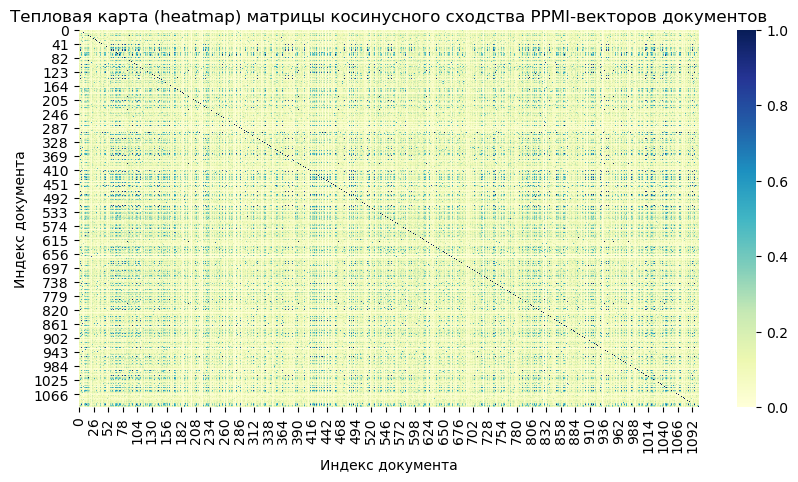

In [37]:
fig = plt.figure(figsize=(10,5),dpi=100)
sns.heatmap(Cos, cmap="YlGnBu")
plt.title('Тепловая карта (heatmap) матрицы косинусного сходства PPMI-векторов документов')
plt.xlabel('Индекс документа')
plt.ylabel('Индекс документа')
plt.savefig('Тепловая карта (heatmap) матрицы косинусного сходства PPMI-векторов документов.png');

In [60]:
vec_15= [trainDataVecs[i] for i in range(15)]
cos_15 = cosine_similarity(vec_15, vec_15)
cos_15

array([[0.99999964, 0.14114337, 0.09889471, 0.07610914, 0.07802173,
        0.1152764 , 0.09950833, 0.07466171, 0.06761061, 0.03206381,
        0.16762103, 0.06732854, 0.1003201 , 0.12356362, 0.07088698],
       [0.14114337, 1.        , 0.1103687 , 0.06864677, 0.0739582 ,
        0.10587265, 0.05904889, 0.04457477, 0.07243428, 0.02098373,
        0.07657453, 0.05164923, 0.11061291, 0.12137172, 0.05138113],
       [0.09889471, 0.1103687 , 1.0000002 , 0.09290282, 0.06303713,
        0.11861147, 0.08964536, 0.06156463, 0.1024368 , 0.02537997,
        0.09303521, 0.06786383, 0.11106665, 0.11179351, 0.06209349],
       [0.07610914, 0.06864677, 0.09290282, 0.99999994, 0.06004357,
        0.08822908, 0.08736012, 0.05614988, 0.05983447, 0.01560879,
        0.07574174, 0.05892753, 0.08183644, 0.10892474, 0.05981318],
       [0.07802173, 0.0739582 , 0.06303713, 0.06004357, 1.0000002 ,
        0.12691833, 0.04431603, 0.07068413, 0.05251554, 0.00830423,
        0.1325942 , 0.08562917, 0.07480383, 

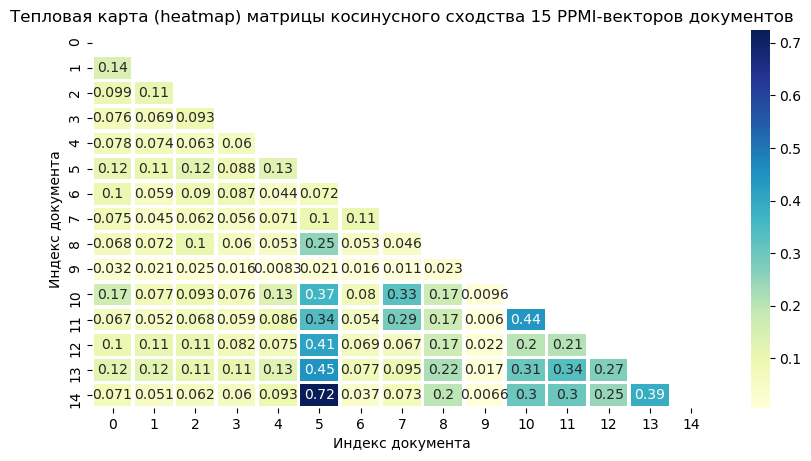

In [67]:
fig = plt.figure(figsize=(10,5),dpi=100)
matrix = np.triu(cos_15)
sns.heatmap(cos_15, cmap="YlGnBu", mask=matrix, annot=True, linewidths=2)
plt.title('Тепловая карта (heatmap) матрицы косинусного сходства 15 PPMI-векторов документов')
plt.xlabel('Индекс документа')
plt.ylabel('Индекс документа')
plt.savefig('Тепловая карта (heatmap) матрицы косинусного сходства 15 PPMI-векторов документов.png');

<Figure size 1000x500 with 0 Axes>

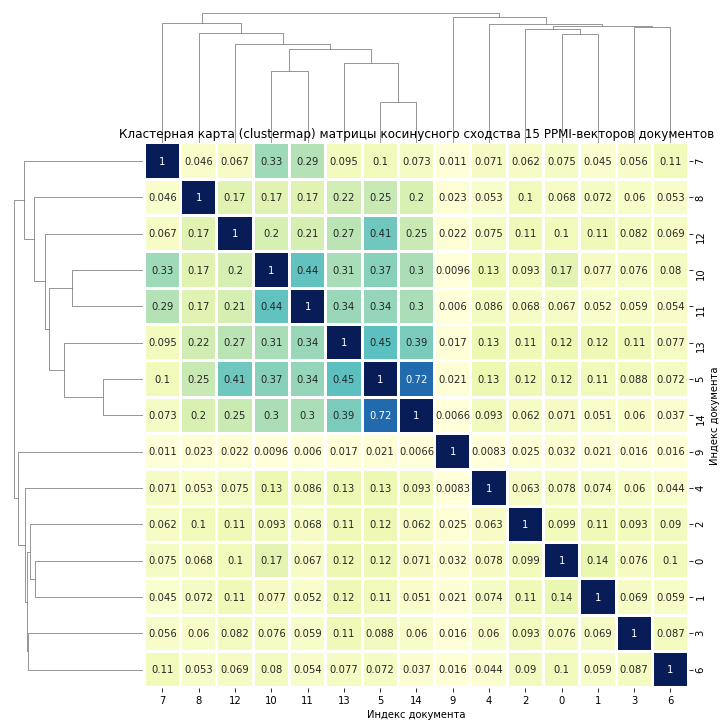

In [140]:
fig = plt.figure(figsize=(10,5),dpi=100)
sns.clustermap(cos_15, cmap="YlGnBu", annot=True, linewidths=2, cbar_pos=None)
plt.title('Кластерная карта (clustermap) матрицы косинусного сходства 15 PPMI-векторов документов')
plt.xlabel('Индекс документа')
plt.ylabel('Индекс документа')
plt.savefig('Кластерная карта (clustermap) матрицы косинусного сходства 15 PPMI-векторов документов.png');

<Figure size 1000x500 with 0 Axes>

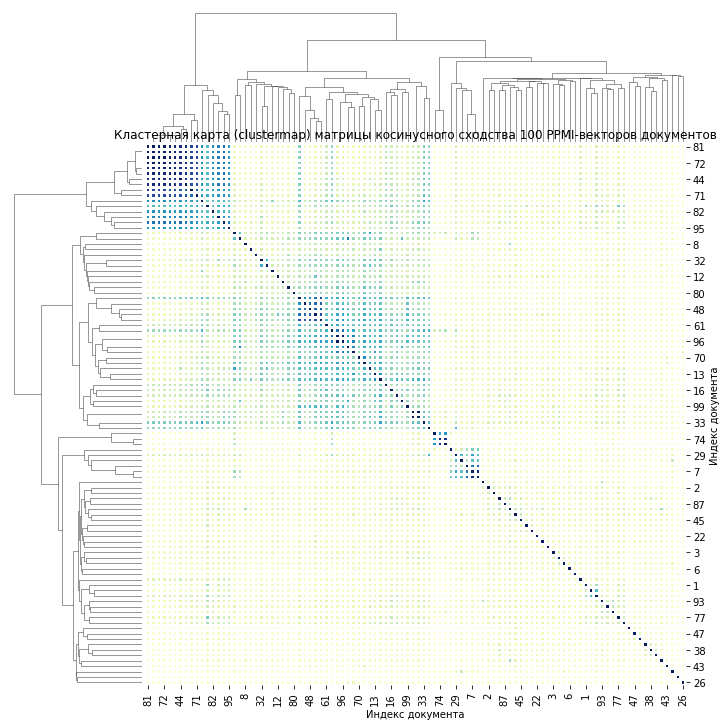

In [119]:
fig = plt.figure(figsize=(10,5),dpi=100)
vec_100= [trainDataVecs[i] for i in range(100)]
cos_100 = cosine_similarity(vec_100, vec_100)
cmap = sns.clustermap(cos_100, cmap="YlGnBu", linewidths=2, cbar_pos=None)
plt.title('Кластерная карта (clustermap) матрицы косинусного сходства 100 PPMI-векторов документов')
plt.xlabel('Индекс документа')
plt.ylabel('Индекс документа')
plt.savefig('Кластерная карта (clustermap) матрицы косинусного сходства 100 PPMI-векторов документов.png');

### 2.4. Визуализация полученных векторов слов

In [21]:
#Выбираем 10000 слов из словаря 

count = 10000
word_vectors_matrix = np.ndarray(shape=(count, ppmi.shape[0]), dtype='float64')
word_list = []
i = 0
for word in ppmi.columns:
    word_vectors_matrix[i] = ppmi[word]
    word_list.append(word)
    i = i+1
    if i == count:
        break
print("word_vectors_matrix shape is ", word_vectors_matrix.shape)

word_vectors_matrix shape is  (10000, 20482)


In [22]:
word_vectors_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [23]:
np.any(np.isnan(word_vectors_matrix))

True

In [24]:
word_vectors_matrix = np.nan_to_num(word_vectors_matrix)

In [25]:
#Сжатие векторов слов в двумерное пространство с помощью tSNE

tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)
word_vectors_matrix_2d = tsne.fit_transform(word_vectors_matrix)
print("word_vectors_matrix_2d shape is ", word_vectors_matrix_2d.shape)

word_vectors_matrix_2d shape is  (10000, 2)


In [26]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1]) 
        for word, coords in [
            (word, word_vectors_matrix_2d[word_list.index(word)])
            for word in word_list
        ]
    ],
    columns=["word", "x", "y"]
)

In [27]:
points

,word,x,y
0,вон,0.075898,-49.409412
1,emsотправление_отправка,0.463314,21.715935
2,неоплаченный_кредит,-43.414745,0.124084
3,преступность,-43.260460,-31.998980
4,успешный_погашение,-1.059840,15.897014
...,...,...,...
9995,видный_кнопка,-42.966892,-14.235603
9996,начать_делать,48.389137,38.820667
9997,попытка,-11.939449,-28.877123
9998,подход,6.795969,-8.404831


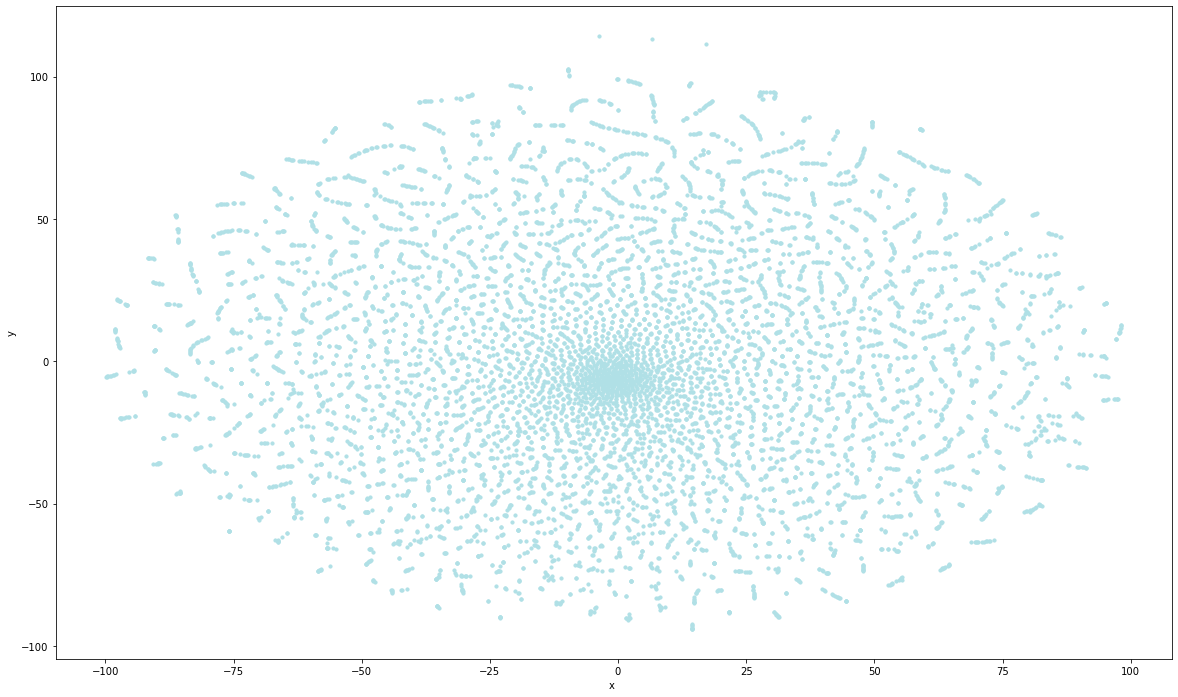

In [28]:
points.plot.scatter("x", "y", s=10, figsize=(20, 12), c = 'powderblue')
plt.xlabel('x ')
plt.ylabel('y')
plt.savefig('PPMI_vectors.png');

In [29]:
def plot_region(x_bounds, y_bounds):
    slice = points[ (x_bounds[0] <= points.x) &
                   (points.x <= x_bounds[1]) &
                   (y_bounds[0] <= points.y) &
                   (points.y <= y_bounds[1])
                  ] 
    ax = slice.plot.scatter("x", "y", s=25, figsize=(10, 8), c = 'powderblue')
    for i, point in slice.iterrows():
        ax.text(point.x + 0.025, point.y + 0.015, point.word, fontsize= 10)
    plt.savefig("PPMI_words_on_OXY")

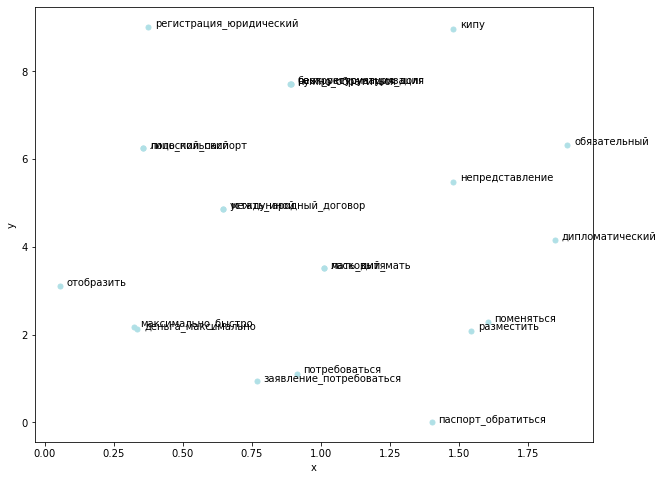

In [30]:
plot_region(x_bounds=(0, 2), y_bounds=(0, 10))

### 2.4. Визуализация полученных векторов тектов

In [30]:
text_vectors_matrix = np.ndarray(shape=(df.shape[0], ppmi.shape[0]), dtype='float64')
text_list = []
for i, text in enumerate(df['text']):
    text_vectors_matrix[i] = trainDataVecs[i]
    text_list.append(text)
print("text_vectors_matrix shape is ", text_vectors_matrix.shape)

text_vectors_matrix shape is  (1104, 20482)


In [37]:
trainDataVecs = np.nan_to_num(trainDataVecs)

In [32]:
text_vectors_matrix = np.nan_to_num(text_vectors_matrix)

In [33]:
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)
text_vectors_matrix_2d = tsne.fit_transform(text_vectors_matrix)
print("text_vectors_matrix_2d shape is ", text_vectors_matrix_2d.shape)

text_vectors_matrix_2d shape is  (1104, 2)


In [34]:
points_text = pd.DataFrame(
    [
        (text, coords[0], coords[1]) 
        for text, coords in [
            (text, text_vectors_matrix_2d[text_list.index(text)])
            for text in text_list
        ]
    ],
    columns=["text", "x", "y"]
)

points_text

,text,x,y
0,связь правило высокий стоимость имущество пере...,-2.175967,12.455014
1,быть правительство брать обязанность выплачива...,4.833228,-2.206529
2,затем потребоваться снять крупный сумма начать...,5.233100,8.441199
3,каждый фирма рубрика услуга микрофинансировани...,12.562645,18.737835
4,минимальный пакет документ минимальный_пакет п...,12.653544,-28.990782
...,...,...,...
1099,наш фирма лидер рынок свой область наш_фирма ф...,1.090533,6.447110
1100,получение заём клиент должный предоставить мин...,-2.188857,-17.286322
1101,поставка оборудование эквайринг предоставление...,11.082508,7.295720
1102,случай непредставление соответствующий докумен...,6.312997,4.454169


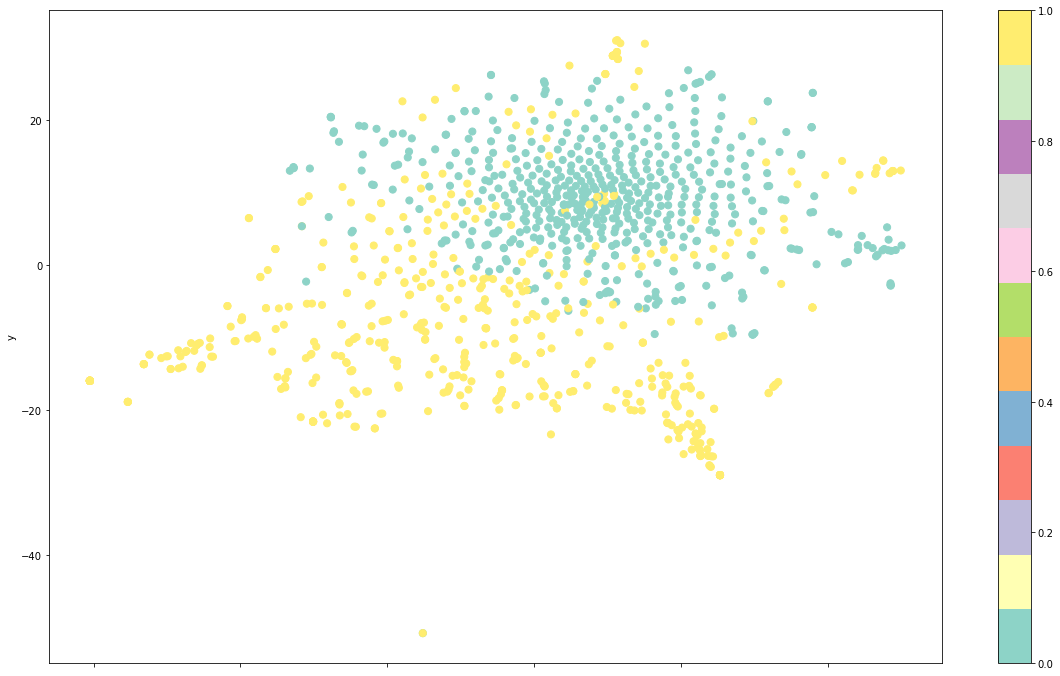

In [35]:
points_text.plot.scatter("x", "y", s=50, figsize=(20, 12), c=df['label'], colormap='Set3')
plt.xlabel('x')
plt.ylabel('y')
plt.savefig('PPMI_vectors_full_texts.png');

### 2.5. TruncatedSVD для снижения размерности

### Подбор k для TruncatedSVD

In [72]:
k = [10000, 5000, 2500, 1000, 500, 250, 50]

In [73]:
from sklearn.utils.extmath import randomized_svd
from numpy.linalg import norm

In [74]:
approx_error = []
trainDataVecs_norm = norm(trainDataVecs, ord = 'fro')
for i in k:
    svd = TruncatedSVD(n_components=i, random_state=0)
    vecs_reduced = svd.fit_transform(trainDataVecs)
    trainDataVecs_new = np.dot(vecs_reduced, svd.components_)
    E = trainDataVecs - trainDataVecs_new 
    E_norm = norm(E, ord = 'fro')
    approx_error.append(E_norm ** 2 / trainDataVecs_norm ** 2 )

In [75]:
approx_error

[6.415226224387908e-11,
 6.645646309987883e-11,
 6.575013204266925e-11,
 4.544780538308134e-06,
 0.05817232533756291,
 0.1411696248747997,
 0.3129248519693835]

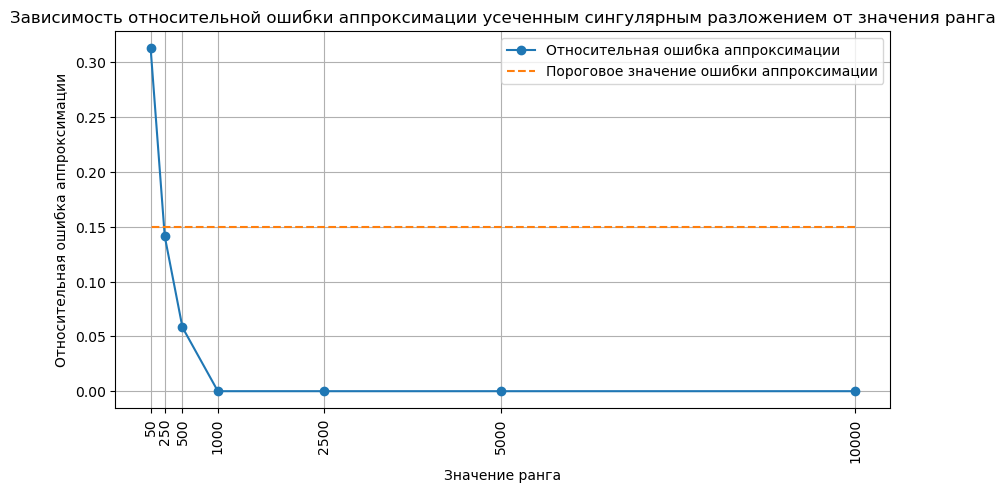

In [88]:
fig = plt.figure(figsize=(10,5),dpi=100)
plt.plot(k, approx_error, marker = 'o', label = 'Относительная ошибка аппроксимации')
plt.grid()
plt.xticks(k, rotation=90)
limit = [0.15 for i in k]
plt.plot(k, limit, '--', label =  'Пороговое значение ошибки аппроксимации')
plt.legend()
plt.xlabel('Значение ранга')
plt.ylabel('Относительная ошибка аппроксимации')
plt.title('Зависимость относительной ошибки аппроксимации усеченным сингулярным разложением от значения ранга')
plt.savefig('Зависимость относительной ошибки аппроксимации усеченным сингулярным разложением от значения ранга.png')

### TruncatedSVD выполнение

In [89]:
svd = TruncatedSVD(n_components=256, random_state=0)
svd.fit(trainDataVecs)

TruncatedSVD(n_components=256, random_state=0)

In [90]:
trSVD_vectors = svd.transform(trainDataVecs)
trSVD_vectors

array([[ 1.8038863 ,  0.9007336 ,  1.8580551 , ...,  0.09123427,
        -0.08491497, -0.03122752],
       [ 1.628274  ,  1.0688426 ,  1.9617528 , ...,  0.0498766 ,
        -0.2427849 , -0.3858961 ],
       [ 1.4037122 ,  0.63036114,  1.7421126 , ...,  0.01757582,
        -0.00939306,  0.11367876],
       ...,
       [ 1.2457557 ,  0.9285516 ,  1.4536351 , ..., -0.18195349,
        -0.12450714, -0.03083256],
       [ 2.2647495 ,  1.3926152 ,  2.1496205 , ...,  0.04264676,
        -0.08667734, -0.37033653],
       [ 2.8655705 ,  3.289508  ,  1.809436  , ..., -0.48251554,
        -0.31196594,  0.22531652]], dtype=float32)

In [91]:
trSVD_vectors.shape

(1104, 256)

### 2.6. Визуализация векторов текстов после TruncatedSVD

In [27]:
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)
text_vectors_matrix_2d_after_Tr_svd = tsne.fit_transform(trSVD_vectors)
print("text_vectors_matrix_2d after SVD shape is ", text_vectors_matrix_2d_after_Tr_svd.shape)

text_vectors_matrix_2d after SVD shape is  (1104, 2)


In [31]:
text_list = []
for i, text in enumerate(df['text']):
    text_list.append(text)

In [32]:
points_text_after_tr_svd = pd.DataFrame(
    [
        (text, coords[0], coords[1]) 
        for text, coords in [
            (text, text_vectors_matrix_2d_after_Tr_svd[text_list.index(text)])
            for text in text_list
        ]
    ],
    columns=["text", "x", "y"]
)

points_text_after_tr_svd

,text,x,y
0,связь правило высокий стоимость имущество пере...,-0.529053,1.062622
1,быть правительство брать обязанность выплачива...,-12.283351,-13.983754
2,затем потребоваться снять крупный сумма начать...,-3.518831,7.043141
3,каждый фирма рубрика услуга микрофинансировани...,-3.875318,4.154082
4,минимальный пакет документ минимальный_пакет п...,2.286881,-47.328110
...,...,...,...
1099,наш фирма лидер рынок свой область наш_фирма ф...,-10.934558,19.422911
1100,получение заём клиент должный предоставить мин...,13.335434,-24.909111
1101,поставка оборудование эквайринг предоставление...,-5.161654,5.084933
1102,случай непредставление соответствующий докумен...,-8.765086,-0.830871


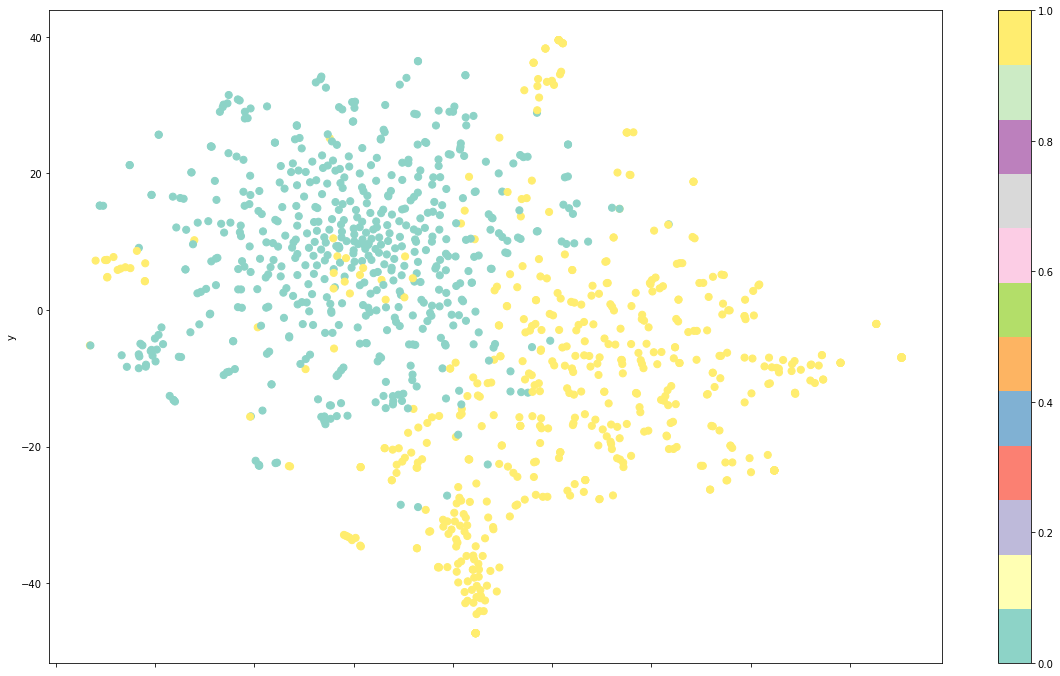

In [35]:
points_text_after_tr_svd.plot.scatter("x", "y", s=50, figsize=(20, 12), c=df['label'], colormap='Set3')
plt.xlabel('x')
plt.ylabel('y')
plt.savefig('PPMI_vectors_full_texts_after_tr_svd.png');

## 3. Классификация с помощью SVM только на векторах текстов

### 3.1. Данные для обучения до SVD и после SVD

In [92]:
trainDataVecs.shape

(1104, 20482)

In [93]:
X1 = pd.DataFrame(trainDataVecs)
X3 = pd.DataFrame(trSVD_vectors)
y = df['label']

In [94]:
X1

,0,1,2,3,4,5,6,7,8,9,...,20472,20473,20474,20475,20476,20477,20478,20479,20480,20481
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.056812,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.216755
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.086874,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.160002
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.128949,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.255502,0.0,0.000000,0.0,0.387984,0.000000,0.0,0.0,0.000000
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.520042,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1099,0.381474,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.158561,0.0,0.000000,0.0,0.000000,0.380301,0.0,0.0,0.000000
1100,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.322274,0.0,...,0.0,0.008606,0.0,0.179408,0.0,0.000000,0.000000,0.0,0.0,0.000000
1101,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000
1102,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.050384,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000


In [96]:
X3

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,1.803886,0.900734,1.858055,-2.574020,-0.992090,-0.531701,-0.096096,0.148046,-0.813945,-0.599964,...,0.092315,-0.353831,-0.412028,-0.248115,-0.623306,0.146660,0.149135,0.091234,-0.084915,-0.031228
1,1.628274,1.068843,1.961753,-2.917632,-1.737412,-1.138654,-0.005930,-0.154552,-2.030103,0.061528,...,-0.028624,-0.197902,-0.109764,-0.303955,-0.144768,0.498168,-0.117882,0.049877,-0.242785,-0.385896
2,1.403712,0.630361,1.742113,-2.010400,-0.850302,-0.299729,0.622786,0.084036,0.801999,-0.329262,...,-0.135647,0.072565,-0.267638,-0.165515,0.021619,-0.042790,0.186787,0.017576,-0.009393,0.113679
3,1.909566,0.780910,1.993621,-2.118073,-0.646504,-0.245425,1.479292,-0.290220,0.300588,-0.345668,...,-0.057635,0.159026,-0.013602,0.444640,-0.071305,0.183084,-0.398353,0.711411,-0.553958,0.057764
4,15.743591,40.792385,-6.949442,5.354801,0.664547,-3.325654,0.517042,0.421432,0.600069,-0.558224,...,0.134048,0.007607,-0.061694,-0.073869,0.159933,0.131234,0.094688,-0.020856,-0.044688,-0.008673
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1099,1.723661,1.043906,2.835019,-4.684922,-1.460223,-1.812584,0.160550,0.473660,0.783559,-3.614860,...,0.759395,-0.130683,0.952881,1.034500,-0.186378,-0.931887,-0.031566,-0.073224,0.237442,0.199503
1100,8.717006,4.677330,4.890178,-2.021007,-0.952087,6.103005,-1.996944,0.422082,-0.516730,2.135627,...,-0.042981,-0.130638,-0.083552,-0.155639,0.056249,0.076411,-0.021459,0.131014,0.044115,-0.085551
1101,1.245756,0.928552,1.453635,-2.115435,-0.205332,-0.357529,0.206390,0.889510,-0.495923,-0.644745,...,0.029159,0.237945,0.221841,-0.406014,0.867964,-0.433502,0.830736,-0.181953,-0.124507,-0.030833
1102,2.264750,1.392615,2.149621,-2.453786,0.212203,0.208220,0.174753,0.421502,0.262023,-0.222781,...,0.048926,-0.057714,0.100580,-0.263714,-0.152629,0.479795,-0.109280,0.042647,-0.086677,-0.370337


In [97]:
y

0       0
1       0
2       0
3       0
4       1
       ..
1099    0
1100    1
1101    0
1102    0
1103    1
Name: label, Length: 1104, dtype: int64

### 3.2. SVC + GridSearchCV до SVD

In [249]:
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size = 0.2, random_state = 101)



In [250]:
param_grid =[{'kernel': ['linear'], 
               'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}, 
             
             {'kernel': ['rbf'], 
              'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
             'gamma': [10, 1, 0.1, 0.01, 0.001, 0.0001]} ]


#{'kernel': ['poly'],  'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],'gamma': [10, 1, 0.1, 0.01, 0.001, 0.0001], 'degree':[0, 1, 2, 3, 4, 5]}
                
                
                

In [320]:
%%time
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3, cv =  RepeatedStratifiedKFold(10,3), n_jobs=-1, 
                    return_train_score=True, scoring='f1')
grid.fit(X_train, y_train)


Fitting 30 folds for each of 49 candidates, totalling 1470 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed: 19.8min
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed: 50.9min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 90.4min
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed: 130.4min
[Parallel(n_jobs=-1)]: Done 1470 out of 1470 | elapsed: 162.5min finished


CPU times: user 9.81 s, sys: 1.26 s, total: 11.1 s
Wall time: 2h 42min 37s


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=10, random_state=None),
             estimator=SVC(), n_jobs=-1,
             param_grid=[{'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                          'kernel': ['linear']},
                         {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                          'gamma': [10, 1, 0.1, 0.01, 0.001, 0.0001],
                          'kernel': ['rbf']}],
             return_train_score=True, scoring='f1', verbose=3)

In [321]:
print(grid.best_params_)
print(grid.best_estimator_)

{'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
SVC(C=100, gamma=0.0001)


In [322]:
grid_predictions = grid.predict(X_test)

print(metrics.classification_report(y_test, grid_predictions))


              precision    recall  f1-score   support

           0       0.98      0.98      0.98       105
           1       0.98      0.98      0.98       116

    accuracy                           0.98       221
   macro avg       0.98      0.98      0.98       221
weighted avg       0.98      0.98      0.98       221



In [323]:
print ('Accuracy (test)=', metrics.accuracy_score(y_test, grid_predictions))
print ('Precision (test) =', metrics.precision_score(y_test, grid_predictions))
print ('Recall(test) =', metrics.recall_score(y_test, grid_predictions))
print ('F1-score (test)=', metrics.f1_score(y_test, grid_predictions))


Accuracy (test)= 0.9819004524886877
Precision (test) = 0.9827586206896551
Recall(test) = 0.9827586206896551
F1-score (test)= 0.9827586206896551


In [324]:
clf = grid.best_estimator_
pred_train = clf.predict(X_train)
print ('Accuracy (train)=', metrics.accuracy_score(y_train, pred_train))
print ('Precision(train) =', metrics.precision_score(y_train, pred_train))
print ('Recall (train)=', metrics.recall_score(y_train, pred_train))
print ('F1-score (train) =', metrics.f1_score(y_train, pred_train))


Accuracy (train)= 0.9977349943374858
Precision(train) = 0.997716894977169
Recall (train)= 0.997716894977169
F1-score (train) = 0.997716894977169


In [325]:
#сохранение полученного классификатора 
joblib.dump(grid.best_estimator_, 'PPMI_SVM.pkl')


['PPMI_SVM.pkl']

In [326]:
scores_acc = cross_val_score(grid.best_estimator_, X1, y, cv=5, scoring = 'accuracy')
scores_pre = cross_val_score(grid.best_estimator_, X1, y, cv=5, scoring = 'precision')
scores_re = cross_val_score(grid.best_estimator_, X1, y, cv=5, scoring = 'recall')
scores_f = cross_val_score(grid.best_estimator_, X1, y, cv=5, scoring = 'f1')


In [327]:
print('Accuracy')
print(scores_acc)
print(np.mean(scores_acc))

print('Precision')
print(scores_pre)
print(np.mean(scores_pre))


print('Recall')
print(scores_re)
print(np.mean(scores_re))

print('F1')
print(scores_f)
print(np.mean(scores_f))


Accuracy
[0.98642534 0.95927602 0.97737557 0.9638009  0.98636364]
0.9746482928835871
Precision
[0.98214286 0.97222222 0.98181818 0.96396396 0.99082569]
0.978194582644124
Recall
[0.99099099 0.94594595 0.97297297 0.96396396 0.98181818]
0.9711384111384112
F1
[0.98654709 0.95890411 0.97737557 0.96396396 0.98630137]
0.9746184188457345


In [328]:
from sklearn.metrics import matthews_corrcoef
matthews_corrcoef(y_test, grid_predictions)


0.9637110016420362

In [329]:
from sklearn.model_selection import validation_curve

train_scores, valid_scores = validation_curve(grid.best_estimator_, X1, y, "C",[0.001, 0.01, 0.1, 1, 10, 100, 1000],
                                              cv=5, n_jobs=-1 )


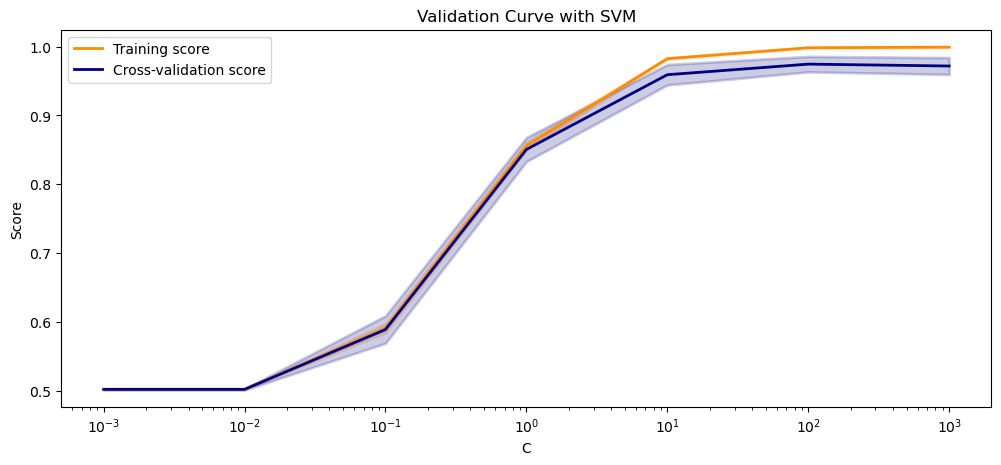

<Figure size 432x288 with 0 Axes>

In [330]:
param_range = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(valid_scores, axis=1)
test_scores_std = np.std(valid_scores, axis=1)


fig = plt.figure(figsize=(12, 5), dpi=100)
plt.title("Validation Curve with SVM")
plt.xlabel("C")
plt.ylabel("Score")
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()
plt.savefig("ppmi_valid_curve_c.png")


In [331]:
train_scores, valid_scores = validation_curve(grid.best_estimator_, X1, y,
                                              "gamma",[10, 1, 0.1, 0.01, 0.001, 0.0001],
                                             cv=5, n_jobs=-1)



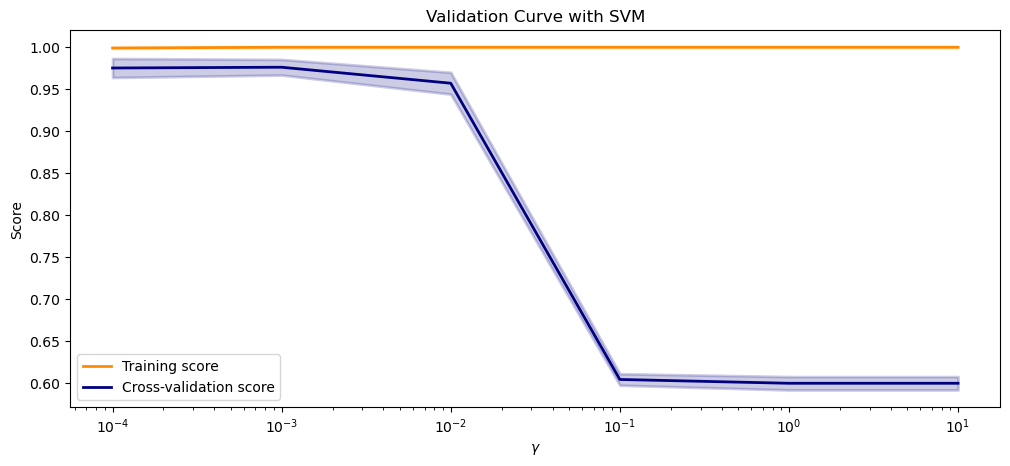

<Figure size 432x288 with 0 Axes>

In [332]:
param_range = [10, 1, 0.1, 0.01, 0.001, 0.0001]
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(valid_scores, axis=1)
test_scores_std = np.std(valid_scores, axis=1)


fig = plt.figure(figsize=(12, 5), dpi=100)
plt.title("Validation Curve with SVM")
plt.xlabel("$\gamma$")
plt.ylabel("Score")
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()
plt.savefig("ppmi_valid_curve_gamma.png")

In [333]:
results = pd.DataFrame(grid.cv_results_)
scores_rbf = np.array(results[results.param_kernel=='rbf'].mean_test_score).reshape(7,6)


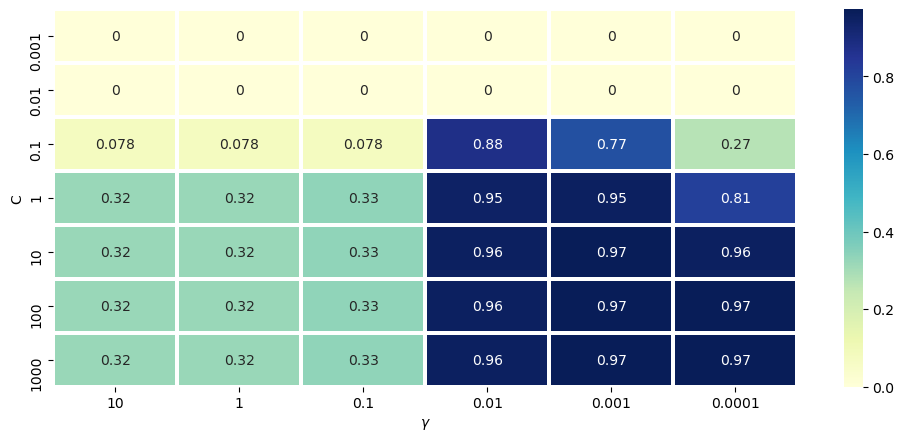

In [334]:
import seaborn as sns 

x1 = 10, 1, 0.1, 0.01, 0.001, 0.0001
y1 = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
fig = plt.figure(figsize=(12, 5), dpi=100)
sns.heatmap(scores_rbf, cmap="YlGnBu", annot=True, linewidths=2, xticklabels=x1, yticklabels=y1)
plt.xlabel("$\gamma$")
plt.ylabel("C")
plt.savefig("ppmi_heatmap_rbf.png")


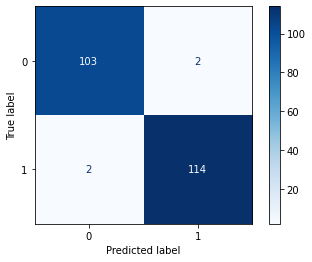

In [475]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, grid_predictions)

cm_display = ConfusionMatrixDisplay(cm).plot(cmap='Blues')
plt.savefig('ppmi_conf_matr.png')


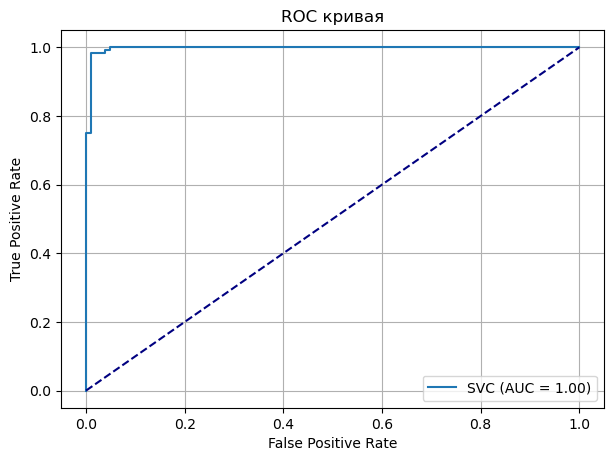

In [336]:
from sklearn.metrics import plot_roc_curve

fig = plt.figure(figsize=(7, 5), dpi=100)
ax = fig.add_subplot(111)
plot_roc_curve(clf, X_test, y_test, ax=ax)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.title("ROC кривая")
plt.grid();
plt.savefig('ppmi_roc_curve.png')


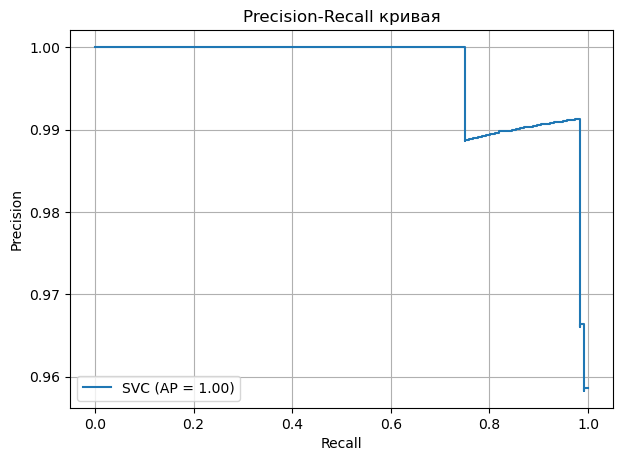

In [337]:
from sklearn.metrics import plot_precision_recall_curve
fig = plt.figure(figsize=(7, 5), dpi=100)
ax = fig.add_subplot(111)
plot_precision_recall_curve(clf, X_test, y_test, ax=ax)
plt.title("Precision-Recall кривая")
plt.grid();
plt.savefig('ppmi_pr_curve.png')


### 3.4. SVC + GridSearchCV после TruncatedSVD

In [304]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X3, y, test_size = 0.25, random_state = 101)


In [305]:
%%time
grid_after_Tr_svd = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3, cv = RepeatedStratifiedKFold(10,3), n_jobs=-1, 
                    return_train_score=True, scoring='f1')
grid_after_Tr_svd.fit(X_train1, y_train1)


Fitting 30 folds for each of 49 candidates, totalling 1470 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 608 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:   41.5s
[Parallel(n_jobs=-1)]: Done 1248 tasks      | elapsed:   58.0s


CPU times: user 2.65 s, sys: 359 ms, total: 3 s
Wall time: 1min 5s


[Parallel(n_jobs=-1)]: Done 1470 out of 1470 | elapsed:  1.1min finished


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=10, random_state=None),
             estimator=SVC(), n_jobs=-1,
             param_grid=[{'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                          'kernel': ['linear']},
                         {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                          'gamma': [10, 1, 0.1, 0.01, 0.001, 0.0001],
                          'kernel': ['rbf']}],
             return_train_score=True, scoring='f1', verbose=3)

In [306]:
print(grid_after_Tr_svd.best_params_)
print(grid_after_Tr_svd.best_estimator_)

grid_predictions_after_Tr_svd = grid_after_Tr_svd.predict(X_test1)

print(metrics.classification_report(y_test1, grid_predictions_after_Tr_svd))


{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
SVC(C=10, gamma=0.001)
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       135
           1       0.98      0.99      0.98       141

    accuracy                           0.98       276
   macro avg       0.98      0.98      0.98       276
weighted avg       0.98      0.98      0.98       276



In [307]:
print ('Accuracy (test) =', metrics.accuracy_score(y_test1, grid_predictions_after_Tr_svd))
print ('Precision (test) =', metrics.precision_score(y_test1, grid_predictions_after_Tr_svd))
print ('Recall (test) =', metrics.recall_score(y_test1, grid_predictions_after_Tr_svd))
print ('F1-score (test) =', metrics.f1_score(y_test1, grid_predictions_after_Tr_svd))


Accuracy (test) = 0.9818840579710145
Precision (test) = 0.9788732394366197
Recall (test) = 0.9858156028368794
F1-score (test) = 0.9823321554770318


In [308]:
clf1 = grid_after_Tr_svd.best_estimator_
pred_train = clf1.predict(X_train1)
print ('Accuracy (train)=', metrics.accuracy_score(y_train1, pred_train))
print ('Precision(train) =', metrics.precision_score(y_train1, pred_train))
print ('Recall (train)=', metrics.recall_score(y_train1, pred_train))
print ('F1-score (train) =', metrics.f1_score(y_train1, pred_train))


Accuracy (train)= 0.9939613526570048
Precision(train) = 0.9975609756097561
Recall (train)= 0.9903147699757869
F1-score (train) = 0.9939246658566222


In [309]:
joblib.dump(grid_after_Tr_svd.best_estimator_, 'PPMI_SVM_after_Truncated_svd.pkl')


['PPMI_SVM_after_Truncated_svd.pkl']

In [310]:
scores_acc = cross_val_score(grid_after_Tr_svd.best_estimator_, X3, y, cv=5, scoring = 'accuracy')
scores_pre = cross_val_score(grid_after_Tr_svd.best_estimator_, X3, y, cv=5, scoring = 'precision')
scores_re = cross_val_score(grid_after_Tr_svd.best_estimator_, X3, y, cv=5, scoring = 'recall')
scores_f = cross_val_score(grid_after_Tr_svd.best_estimator_, X3, y, cv=5, scoring = 'f1')


In [311]:
print('Accuracy')
print(scores_acc)
print(np.mean(scores_acc))

print('Precision')
print(scores_pre)
print(np.mean(scores_pre))


print('Recall')
print(scores_re)
print(np.mean(scores_re))

print('F1')
print(scores_f)
print(np.mean(scores_f))

Accuracy
[0.98642534 0.97737557 0.96832579 0.97285068 0.98636364]
0.9782682023858496
Precision
[0.98214286 0.99074074 0.97272727 0.97297297 0.99082569]
0.9818819063314477
Recall
[0.99099099 0.96396396 0.96396396 0.97297297 0.98181818]
0.9747420147420147
F1
[0.98654709 0.97716895 0.96832579 0.97297297 0.98630137]
0.9782632339329348


In [312]:
matthews_corrcoef(y_test1, grid_predictions_after_Tr_svd)

0.9637706071604957

In [313]:
results = pd.DataFrame(grid_after_Tr_svd.cv_results_)
scores_rbf = np.array(results[results.param_kernel=='rbf'].mean_test_score).reshape(7,6)


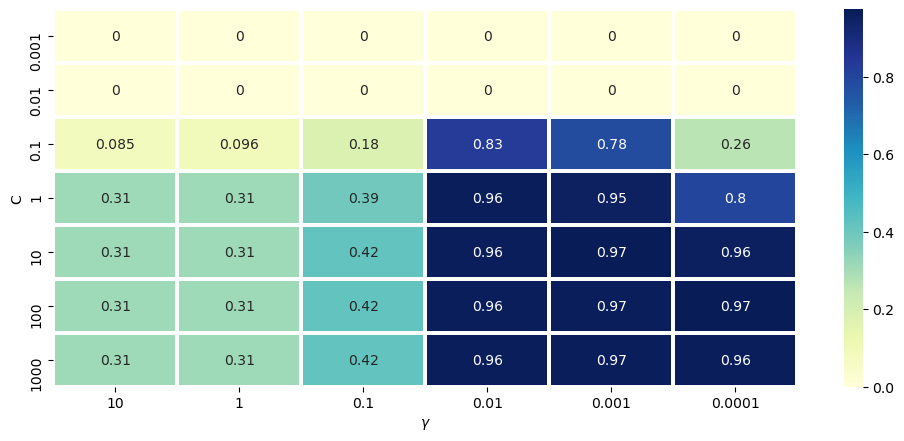

In [314]:
import seaborn as sns 

x1 = 10, 1, 0.1, 0.01, 0.001, 0.0001
y1 = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
fig = plt.figure(figsize=(12, 5), dpi=100)
sns.heatmap(scores_rbf, cmap="YlGnBu", annot=True, linewidths=2, xticklabels=x1, yticklabels=y1)
plt.xlabel("$\gamma$")
plt.ylabel("C")
plt.savefig("ppmi_tr_svd_heatmap_rbf.png")

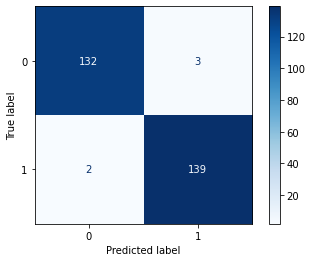

In [476]:
cm = confusion_matrix(y_test1, grid_predictions_after_Tr_svd)

cm_display = ConfusionMatrixDisplay(cm).plot(cmap='Blues')
plt.savefig('ppmi_tr_svd_conf_matrix.png')

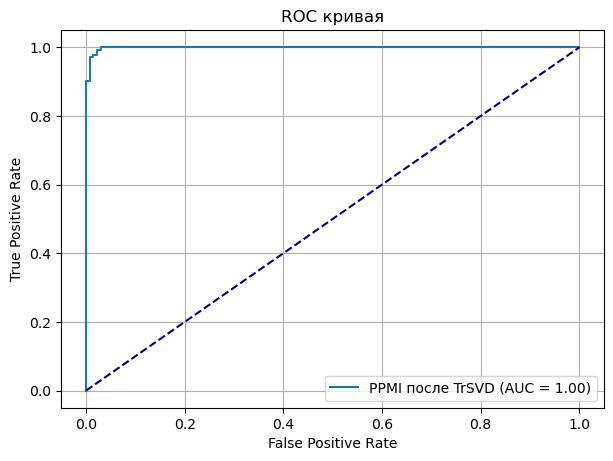

In [316]:
fig = plt.figure(figsize=(7, 5), dpi=100)
ax = fig.add_subplot(111)
plot_roc_curve(clf1, X_test1, y_test1, ax=ax,name='PPMI после TrSVD' )
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.title("ROC кривая")
plt.grid();
plt.savefig('ppmi_tr_svd_roc_curve.png')

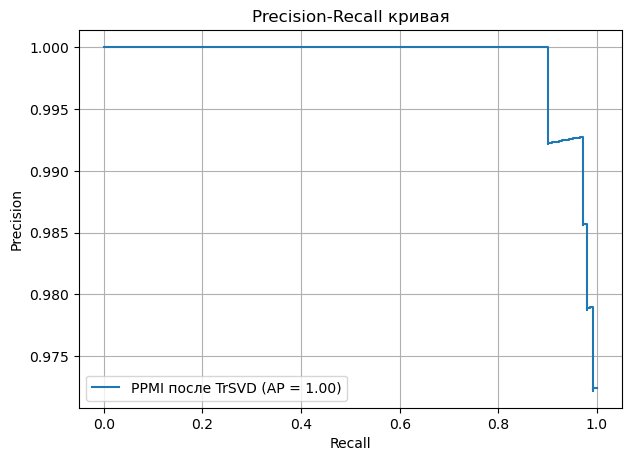

In [317]:
fig = plt.figure(figsize=(7, 5), dpi=100)
ax = fig.add_subplot(111)
plot_precision_recall_curve(clf1, X_test1, y_test1, ax=ax, name='PPMI после TrSVD')
plt.title("Precision-Recall кривая")
plt.grid();
plt.savefig('ppmi_tr_svd_pr_curve.png')

## 4. Классификация на векторах текстов до SVD с дополнительными признаками на основе URL 

### 4.1. Данные для обучения с дополнительными признаками

In [7]:
df_add = pd.read_csv('additional_features_norm.csv')


In [339]:
X_new = X1.join(df_add)


In [340]:
X_new


,0,1,2,3,4,5,6,7,8,9,...,whois_updatedDate,dot_count,url_len,digit_count,special_count,hyphen_count,double_slash,single_slash,protocol,protocol_count
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,-1.000000,-1.0,-0.790660,-1.000000,-1.0,-0.655172,-1.0,-0.666667,1.0,-1.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,-1.000000,-1.0,-0.764895,-1.000000,-1.0,-0.586207,-1.0,-0.666667,1.0,-1.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,-0.834471,-1.0,-0.864734,-0.984252,-1.0,-0.724138,-1.0,-0.666667,1.0,-1.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,-1.000000,-0.6,-0.877617,-1.000000,-1.0,-1.000000,-1.0,-0.555556,1.0,-1.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.520042,0.0,...,-1.000000,-1.0,-0.913043,-0.889764,-1.0,-1.000000,-1.0,-0.666667,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1099,0.381474,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,-0.634812,-0.6,-0.945250,-1.000000,-1.0,-0.931034,-1.0,-0.888889,1.0,-1.0
1100,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.322274,0.0,...,-1.000000,-1.0,-0.896940,-0.889764,-1.0,-1.000000,-1.0,-0.666667,-1.0,-1.0
1101,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,-1.000000,-1.0,-0.919485,-0.952756,-1.0,-1.000000,-1.0,-0.666667,1.0,-1.0
1102,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,-1.000000,-1.0,-0.909823,-1.000000,-1.0,-0.931034,-1.0,-0.666667,1.0,-1.0


### 4.3. Подбор параметров 


In [341]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_new, y, test_size = 0.25, random_state = 101)

In [342]:
grid_new = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3, cv = RepeatedStratifiedKFold(10,3), n_jobs=-1, 
                    return_train_score=True, scoring='f1')

grid_new.fit(X_train2, y_train2)


Fitting 30 folds for each of 49 candidates, totalling 1470 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed: 17.3min
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed: 45.2min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 80.2min
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed: 115.5min
[Parallel(n_jobs=-1)]: Done 1470 out of 1470 | elapsed: 145.5min finished


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=10, random_state=None),
             estimator=SVC(), n_jobs=-1,
             param_grid=[{'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                          'kernel': ['linear']},
                         {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                          'gamma': [10, 1, 0.1, 0.01, 0.001, 0.0001],
                          'kernel': ['rbf']}],
             return_train_score=True, scoring='f1', verbose=3)

In [343]:
print(grid_new.best_params_)
print(grid_new.best_estimator_)

new_grid_predictions = grid_new.predict(X_test2)
print(metrics.classification_report(y_test2, new_grid_predictions))


{'C': 0.01, 'kernel': 'linear'}
SVC(C=0.01, kernel='linear')
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       135
           1       0.99      1.00      1.00       141

    accuracy                           1.00       276
   macro avg       1.00      1.00      1.00       276
weighted avg       1.00      1.00      1.00       276



In [344]:
print ('Accuracy (test) =', metrics.accuracy_score(y_test2, new_grid_predictions))
print ('Precision (test)=', metrics.precision_score(y_test2, new_grid_predictions))
print ('Recall (test)=', metrics.recall_score(y_test2, new_grid_predictions))
print ('F1-score (test) =', metrics.f1_score(y_test2, new_grid_predictions))


Accuracy (test) = 0.9963768115942029
Precision (test)= 0.9929577464788732
Recall (test)= 1.0
F1-score (test) = 0.9964664310954063


In [345]:
clf2 = grid_new.best_estimator_
pred_train = clf2.predict(X_train2)
print ('Accuracy (train)=', metrics.accuracy_score(y_train2, pred_train))
print ('Precision(train) =', metrics.precision_score(y_train2, pred_train))
print ('Recall (train)=', metrics.recall_score(y_train2, pred_train))
print ('F1-score (train) =', metrics.f1_score(y_train2, pred_train))

Accuracy (train)= 0.9975845410628019
Precision(train) = 0.9975786924939467
Recall (train)= 0.9975786924939467
F1-score (train) = 0.9975786924939467


In [346]:
#сохранение полученного классификатора 
joblib.dump(grid_new.best_estimator_, 'PPMI_SVM_with_add_features.pkl')

['PPMI_SVM_with_add_features.pkl']

In [347]:
scores_acc = cross_val_score(grid_new.best_estimator_, X_new, y, cv=5, scoring = 'accuracy')
scores_pre = cross_val_score(grid_new.best_estimator_, X_new, y, cv=5, scoring = 'precision')
scores_re = cross_val_score(grid_new.best_estimator_, X_new, y, cv=5, scoring = 'recall')
scores_f = cross_val_score(grid_new.best_estimator_, X_new, y, cv=5, scoring = 'f1')

In [348]:
print('Accuracy')
print(scores_acc)
print(np.mean(scores_acc))

print('Precision')
print(scores_pre)
print(np.mean(scores_pre))


print('Recall')
print(scores_re)
print(np.mean(scores_re))

print('F1')
print(scores_f)
print(np.mean(scores_f))

Accuracy
[0.99095023 0.98190045 0.99547511 0.99095023 0.99545455]
0.9909461127108186
Precision
[0.98230088 0.99082569 0.99107143 1.         1.        ]
0.9928396003201151
Recall
[1.         0.97297297 1.         0.98198198 0.99090909]
0.9891728091728093
F1
[0.99107143 0.98181818 0.9955157  0.99090909 0.99543379]
0.9909496372640607


In [349]:
matthews_corrcoef(y_test2, new_grid_predictions)

0.9927751527472688

In [350]:
results = pd.DataFrame(grid_new.cv_results_)
scores_rbf = np.array(results[results.param_kernel=='rbf'].mean_test_score).reshape(7,6)

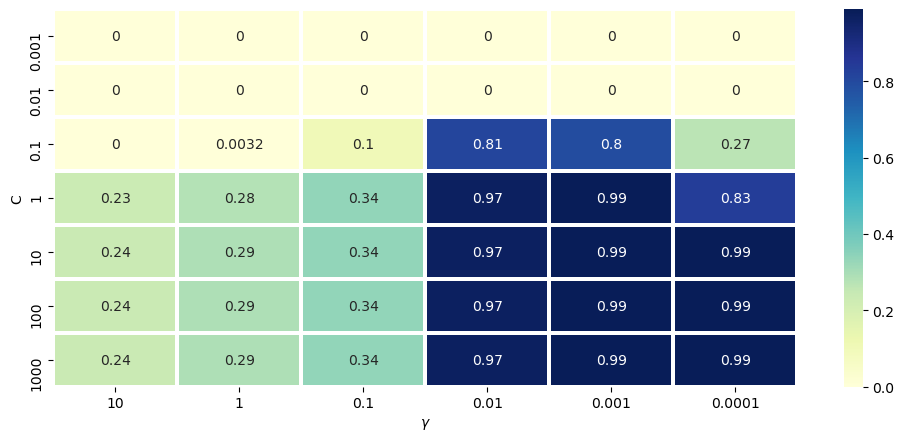

In [351]:
x1 = 10, 1, 0.1, 0.01, 0.001, 0.0001
y1 = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
fig = plt.figure(figsize=(12, 5), dpi=100)
sns.heatmap(scores_rbf, cmap="YlGnBu", annot=True, linewidths=2, xticklabels=x1, yticklabels=y1)
plt.xlabel("$\gamma$")
plt.ylabel("C")
plt.savefig("ppmi_addFeatures_heatmap_rbf.png")

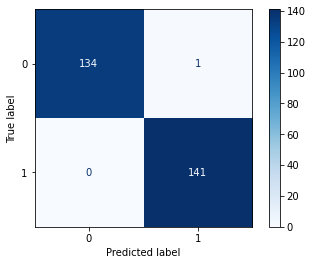

In [477]:
cm = confusion_matrix(y_test2, new_grid_predictions)

cm_display = ConfusionMatrixDisplay(cm).plot(cmap='Blues')
plt.savefig('ppmi_addFeatures_svd_conf_matrix.png')

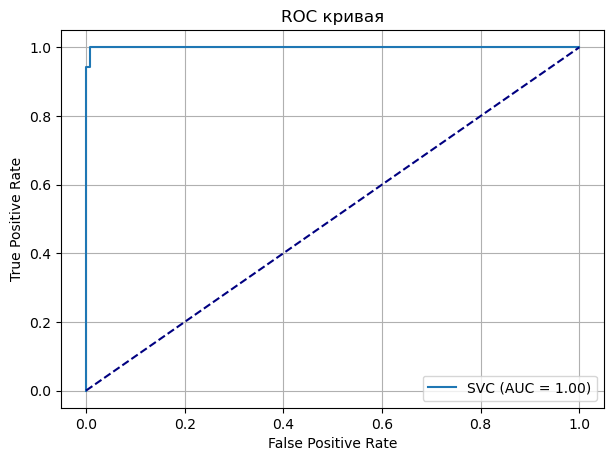

In [353]:
fig = plt.figure(figsize=(7, 5), dpi=100)
ax = fig.add_subplot(111)
plot_roc_curve(clf2, X_test2, y_test2, ax=ax )
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.title("ROC кривая")
plt.grid();
plt.savefig('ppmi_addFeatures_svd_roc_curve.png')

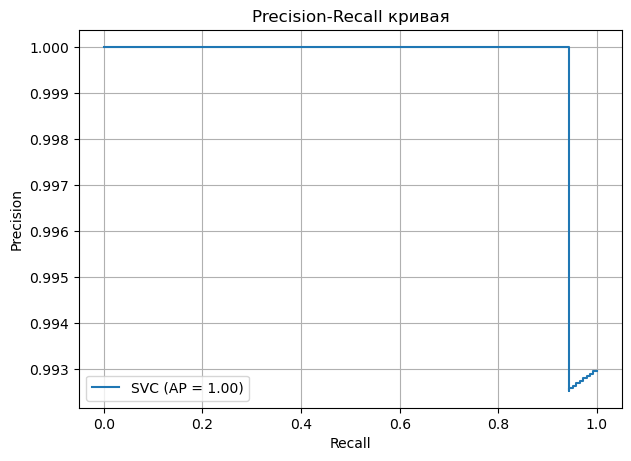

In [354]:
fig = plt.figure(figsize=(7, 5), dpi=100)
ax = fig.add_subplot(111)
plot_precision_recall_curve(clf2, X_test2, y_test2, ax=ax)
plt.title("Precision-Recall кривая")
plt.grid();
plt.savefig('ppmi_addFeatures_pr_curve.png')

## 6. Классификация на векторах текстов после TruncatedSVD с дополнительными признаками на основе URL 

### 6.1. Данные для обучения

In [212]:
X_new_after_Tr_svd = X3.join(df_add)


In [213]:
X_new_after_Tr_svd

,0,1,2,3,4,5,6,7,8,9,...,whois_updatedDate,dot_count,url_len,digit_count,special_count,hyphen_count,double_slash,single_slash,protocol,protocol_count
0,1.803886,0.900734,1.858055,-2.574020,-0.992090,-0.531701,-0.096096,0.148046,-0.813945,-0.599964,...,-1.000000,-1.0,-0.790660,-1.000000,-1.0,-0.655172,-1.0,-0.666667,1.0,-1.0
1,1.628274,1.068843,1.961753,-2.917632,-1.737412,-1.138654,-0.005930,-0.154552,-2.030103,0.061528,...,-1.000000,-1.0,-0.764895,-1.000000,-1.0,-0.586207,-1.0,-0.666667,1.0,-1.0
2,1.403712,0.630361,1.742113,-2.010400,-0.850302,-0.299729,0.622786,0.084036,0.801999,-0.329262,...,-0.834471,-1.0,-0.864734,-0.984252,-1.0,-0.724138,-1.0,-0.666667,1.0,-1.0
3,1.909566,0.780910,1.993621,-2.118073,-0.646504,-0.245425,1.479292,-0.290220,0.300588,-0.345668,...,-1.000000,-0.6,-0.877617,-1.000000,-1.0,-1.000000,-1.0,-0.555556,1.0,-1.0
4,15.743591,40.792385,-6.949442,5.354801,0.664547,-3.325654,0.517042,0.421432,0.600069,-0.558224,...,-1.000000,-1.0,-0.913043,-0.889764,-1.0,-1.000000,-1.0,-0.666667,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1099,1.723661,1.043906,2.835019,-4.684922,-1.460223,-1.812584,0.160550,0.473660,0.783559,-3.614860,...,-0.634812,-0.6,-0.945250,-1.000000,-1.0,-0.931034,-1.0,-0.888889,1.0,-1.0
1100,8.717006,4.677330,4.890178,-2.021007,-0.952087,6.103005,-1.996944,0.422082,-0.516730,2.135627,...,-1.000000,-1.0,-0.896940,-0.889764,-1.0,-1.000000,-1.0,-0.666667,-1.0,-1.0
1101,1.245756,0.928552,1.453635,-2.115435,-0.205332,-0.357529,0.206390,0.889510,-0.495923,-0.644745,...,-1.000000,-1.0,-0.919485,-0.952756,-1.0,-1.000000,-1.0,-0.666667,1.0,-1.0
1102,2.264750,1.392615,2.149621,-2.453786,0.212203,0.208220,0.174753,0.421502,0.262023,-0.222781,...,-1.000000,-1.0,-0.909823,-1.000000,-1.0,-0.931034,-1.0,-0.666667,1.0,-1.0


### 6.3. Подбор параметров

In [291]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(X_new_after_Tr_svd, y, test_size = 0.25, random_state = 101)


In [292]:
grid_new_after_Tr_svd = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3, cv = RepeatedStratifiedKFold(10,3), n_jobs=-1, 
                    return_train_score=True, scoring='f1')

grid_new_after_Tr_svd.fit(X_train3, y_train3)

Fitting 30 folds for each of 49 candidates, totalling 1470 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 440 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 888 tasks      | elapsed:   42.1s
[Parallel(n_jobs=-1)]: Done 1328 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1470 out of 1470 | elapsed:  1.1min finished


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=10, random_state=None),
             estimator=SVC(), n_jobs=-1,
             param_grid=[{'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                          'kernel': ['linear']},
                         {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                          'gamma': [10, 1, 0.1, 0.01, 0.001, 0.0001],
                          'kernel': ['rbf']}],
             return_train_score=True, scoring='f1', verbose=3)

In [293]:
print(grid_new_after_Tr_svd.best_params_)
print(grid_new_after_Tr_svd.best_estimator_)

new_grid_predictions_after_Tr_svd = grid_new_after_Tr_svd.predict(X_test3)
print(metrics.classification_report(y_test3, new_grid_predictions_after_Tr_svd))

{'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
SVC(C=100, gamma=0.0001)
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       135
           1       0.99      1.00      1.00       141

    accuracy                           1.00       276
   macro avg       1.00      1.00      1.00       276
weighted avg       1.00      1.00      1.00       276



In [294]:
print ('Accuracy (test) =', metrics.accuracy_score(y_test3, new_grid_predictions_after_Tr_svd))
print ('Precision (test)=', metrics.precision_score(y_test3, new_grid_predictions_after_Tr_svd))
print ('Recall (test)=', metrics.recall_score(y_test3, new_grid_predictions_after_Tr_svd))
print ('F1-score (test) =', metrics.f1_score(y_test3, new_grid_predictions_after_Tr_svd))

Accuracy (test) = 0.9963768115942029
Precision (test)= 0.9929577464788732
Recall (test)= 1.0
F1-score (test) = 0.9964664310954063


In [295]:
clf3 = grid_new_after_Tr_svd.best_estimator_
pred_train = clf3.predict(X_train3)
print ('Accuracy (train)=', metrics.accuracy_score(y_train3, pred_train))
print ('Precision(train) =', metrics.precision_score(y_train3, pred_train))
print ('Recall (train)=', metrics.recall_score(y_train3, pred_train))
print ('F1-score (train) =', metrics.f1_score(y_train3, pred_train))

Accuracy (train)= 0.9975845410628019
Precision(train) = 0.9975786924939467
Recall (train)= 0.9975786924939467
F1-score (train) = 0.9975786924939467


In [296]:
scores_acc = cross_val_score(grid_new_after_Tr_svd.best_estimator_, X_new_after_Tr_svd, y, cv=5, scoring = 'accuracy')
scores_pre = cross_val_score(grid_new_after_Tr_svd.best_estimator_, X_new_after_Tr_svd, y, cv=5, scoring = 'precision')
scores_re = cross_val_score(grid_new_after_Tr_svd.best_estimator_, X_new_after_Tr_svd, y, cv=5, scoring = 'recall')
scores_f = cross_val_score(grid_new_after_Tr_svd.best_estimator_, X_new_after_Tr_svd, y, cv=5, scoring = 'f1')

In [297]:
print('Accuracy')
print(scores_acc)
print(np.mean(scores_acc))

print('Precision')
print(scores_pre)
print(np.mean(scores_pre))


print('Recall')
print(scores_re)
print(np.mean(scores_re))

print('F1')
print(scores_f)
print(np.mean(scores_f))

Accuracy
[0.99547511 0.98190045 0.99095023 0.99547511 0.99090909]
0.9909419991772934
Precision
[0.99107143 0.99082569 0.98230088 1.         1.        ]
0.9928396003201151
Recall
[1.         0.97297297 1.         0.99099099 0.98181818]
0.9891564291564292
F1
[0.9955157  0.98181818 0.99107143 0.99547511 0.99082569]
0.9909412213304882


In [235]:
joblib.dump(grid_new_after_Tr_svd.best_estimator_, 'PPMI_SVM_with_add_features_after_Tr_svd.pkl')

['PPMI_SVM_with_add_features_after_Tr_svd.pkl']

In [298]:
matthews_corrcoef(y_test3, new_grid_predictions_after_Tr_svd)

0.9927751527472688

In [299]:
results = pd.DataFrame(grid_new_after_Tr_svd.cv_results_)
scores_rbf = np.array(results[results.param_kernel=='rbf'].mean_test_score).reshape(7,6)

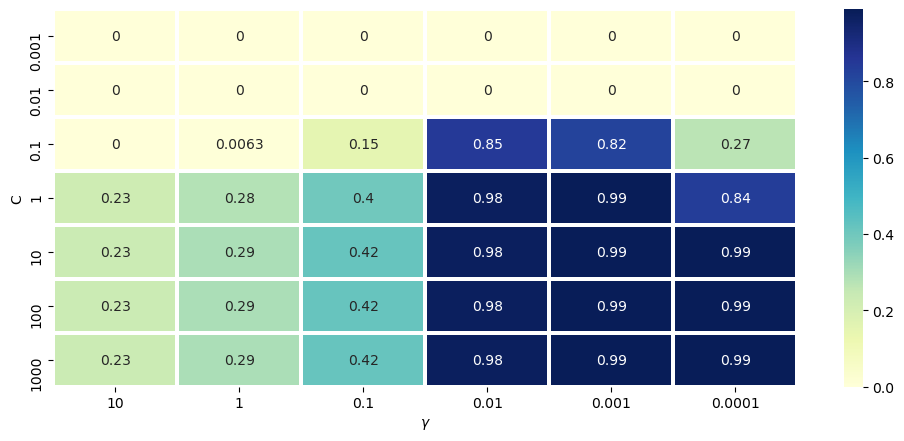

In [300]:
x1 = 10, 1, 0.1, 0.01, 0.001, 0.0001
y1 = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
fig = plt.figure(figsize=(12, 5), dpi=100)
sns.heatmap(scores_rbf, cmap="YlGnBu", annot=True, linewidths=2, xticklabels=x1, yticklabels=y1)
plt.xlabel("$\gamma$")
plt.ylabel("C")
plt.savefig("ppmi_TrSVD_addFeatures_heatmap_rbf.png")

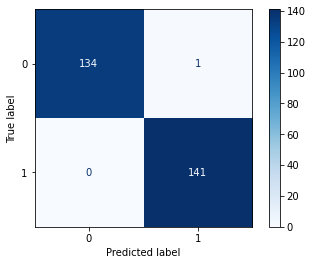

In [478]:
cm = confusion_matrix(y_test3, new_grid_predictions_after_Tr_svd)

cm_display = ConfusionMatrixDisplay(cm).plot(cmap='Blues')
plt.savefig('ppmi_TrSVD_addFeatures_svd_conf_matrix.png')


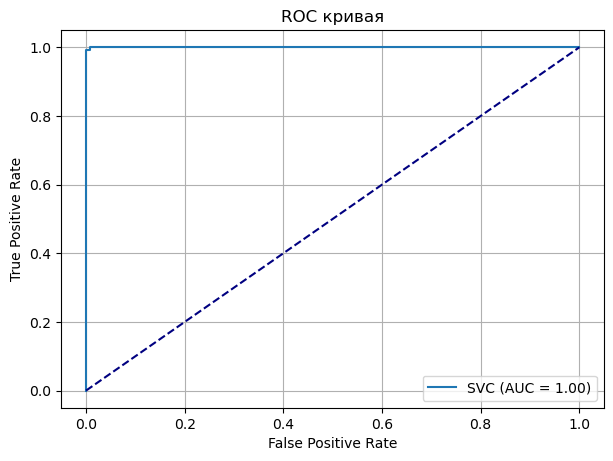

In [302]:
fig = plt.figure(figsize=(7, 5), dpi=100)
ax = fig.add_subplot(111)
plot_roc_curve(clf3, X_test3, y_test3, ax=ax )
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.title("ROC кривая")
plt.grid();
plt.savefig('ppmi_TrSVD_addFeatures_svd_roc_curve.png')

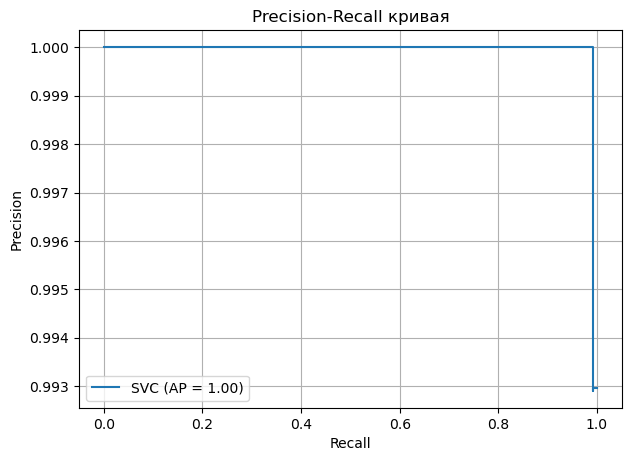

In [303]:
fig = plt.figure(figsize=(7, 5), dpi=100)
ax = fig.add_subplot(111)
plot_precision_recall_curve(clf3, X_test3, y_test3, ax=ax)
plt.title("Precision-Recall кривая")
plt.grid();
plt.savefig('ppmi_TrSVD_addFeatures_pr_curve.png')

### Общие графики

In [453]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import average_precision_score

from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score

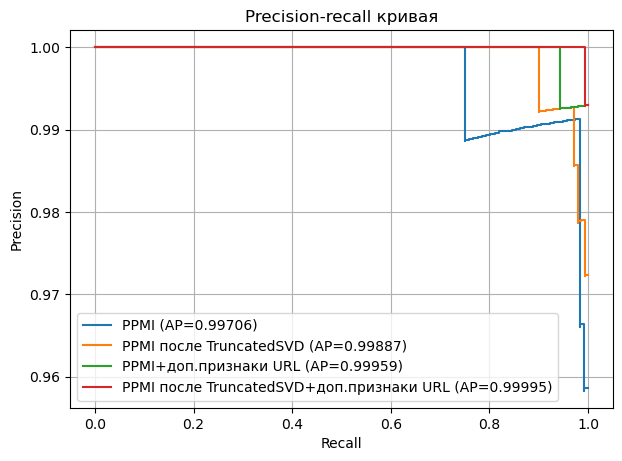

In [452]:
fig = plt.figure(figsize=(7, 5), dpi=100)
ax = fig.add_subplot(111)

prec, recall, _ = precision_recall_curve(y_test, clf.decision_function(X_test))
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot(ax=ax, name='PPMI (AP={0:0.5f})'.format(average_precision_score(y_test, clf.decision_function(X_test))))

prec1, recall1, _ = precision_recall_curve(y_test1, clf1.decision_function(X_test1))
pr_display1 = PrecisionRecallDisplay(precision=prec1, recall=recall1).plot(ax=ax, name='PPMI после TruncatedSVD (AP={0:0.5f})'.format(average_precision_score(y_test1, clf1.decision_function(X_test1))))

prec2, recall2, _ = precision_recall_curve(y_test2, clf2.decision_function(X_test2))
pr_display2 = PrecisionRecallDisplay(precision=prec2, recall=recall2).plot(ax=ax, name='PPMI+доп.признаки URL (AP={0:0.5f})'.format(average_precision_score(y_test2, clf2.decision_function(X_test2))))

prec3, recall3, _ = precision_recall_curve(y_test3, clf3.decision_function(X_test3))
pr_display2 = PrecisionRecallDisplay(precision=prec3, recall=recall3).plot(ax=ax, name='PPMI после TruncatedSVD+доп.признаки URL (AP={0:0.5f})'.format(average_precision_score(y_test3, clf3.decision_function(X_test3))))

plt.title("Precision-recall кривая")
plt.grid();
plt.savefig("PPMI_all_pr_curves.png")

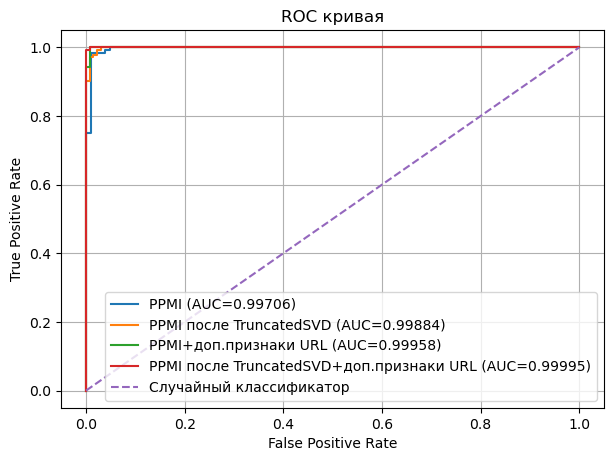

In [461]:
fig = plt.figure(figsize=(7, 5), dpi=100)
ax = fig.add_subplot(111)

fpr, tpr, _ = roc_curve(y_test, clf.decision_function(X_test))
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax, name='PPMI (AUC={0:0.5f})'.format(average_precision_score(y_test, clf.decision_function(X_test))))

fpr1, tpr1, _= roc_curve(y_test1, clf1.decision_function(X_test1))
roc_display1 = RocCurveDisplay(fpr=fpr1, tpr=tpr1).plot(ax=ax, name='PPMI после TruncatedSVD (AUC={0:0.5f})'.format(roc_auc_score(y_test1, clf1.decision_function(X_test1))))

fpr2, tpr2, _= roc_curve(y_test2, clf2.decision_function(X_test2))
roc_display2 = RocCurveDisplay(fpr=fpr2, tpr=tpr2).plot(ax=ax, name='PPMI+доп.признаки URL (AUC={0:0.5f})'.format(roc_auc_score(y_test2, clf2.decision_function(X_test2))))

fpr3, tpr3, _ = roc_curve(y_test3, clf3.decision_function(X_test3))
roc_display3 = RocCurveDisplay(fpr=fpr3, tpr=tpr3).plot(ax=ax, name='PPMI после TruncatedSVD+доп.признаки URL (AUC={0:0.5f})'.format(roc_auc_score(y_test3, clf3.decision_function(X_test3))))

plt.plot([0, 1], [0, 1], linestyle='--', label='Случайный классификатор')
plt.legend()
plt.title("ROC кривая")
plt.savefig("PPMI_all_roc_curves.png")
plt.grid();

### Значимость URL признаков 

In [8]:
loaded_model = joblib.load('PPMI_SVM_with_add_features.pkl')

In [9]:
svm_coef = loaded_model.coef_

In [10]:
svm_coef[0][-12:]

array([ 8.71727634e-02, -4.96105634e-03,  2.45199730e-02, -1.07651828e-02,
        1.53547264e-02,  1.70832588e-02, -1.35350268e-02,  2.82936841e-02,
        2.44595319e-03,  2.00123783e-02, -4.27299303e-01, -1.41379963e-16])

In [11]:
url_feature_importance = pd.DataFrame(svm_coef[0][-12:])

In [14]:
url_features = list(df_add.columns)
feature_names = {}
for i in range(12):
    feature_names[i] = url_features[i]

In [15]:
feature_names

{0: 'whois_regDate',
 1: 'whois_expDate',
 2: 'whois_updatedDate',
 3: 'dot_count',
 4: 'url_len',
 5: 'digit_count',
 6: 'special_count',
 7: 'hyphen_count',
 8: 'double_slash',
 9: 'single_slash',
 10: 'protocol',
 11: 'protocol_count'}

In [16]:
url_feature_importance = url_feature_importance.rename(index= feature_names, columns={0:'svm_coef'})
url_feature_importance

,svm_coef
whois_regDate,8.717276e-02
whois_expDate,-4.961056e-03
whois_updatedDate,2.451997e-02
dot_count,-1.076518e-02
url_len,1.535473e-02
digit_count,1.708326e-02
special_count,-1.353503e-02
hyphen_count,2.829368e-02
double_slash,2.445953e-03
single_slash,2.001238e-02


In [19]:
url_feature_importance = url_feature_importance.sort_values(by='svm_coef', ascending=False)


In [20]:
url_feature_importance['abs(svm_coef)'] = np.abs(url_feature_importance.svm_coef)

In [25]:
url_feature_importance.sort_values(by='abs(svm_coef)', ascending=False)

,svm_coef,abs(svm_coef)
protocol,-4.272993e-01,4.272993e-01
whois_regDate,8.717276e-02,8.717276e-02
hyphen_count,2.829368e-02,2.829368e-02
whois_updatedDate,2.451997e-02,2.451997e-02
single_slash,2.001238e-02,2.001238e-02
digit_count,1.708326e-02,1.708326e-02
url_len,1.535473e-02,1.535473e-02
special_count,-1.353503e-02,1.353503e-02
dot_count,-1.076518e-02,1.076518e-02
whois_expDate,-4.961056e-03,4.961056e-03


In [56]:
url_feature_importance.to_csv('url_feature_importance.csv')

In [69]:
df_add.describe()

,whois_regDate,whois_expDate,whois_updatedDate,dot_count,url_len,digit_count,special_count,hyphen_count,double_slash,single_slash,protocol,protocol_count
count,1104.000000,1104.000000,1104.000000,1104.000000,1104.000000,1104.000000,1104.000000,1104.000000,1104.000000,1104.000000,1104.000000,1104.0
mean,-0.107575,-0.848855,-0.873791,-0.814855,-0.858862,-0.932807,-0.949146,-0.881872,-0.911232,-0.729771,0.117754,-1.0
std,0.606839,0.189582,0.268748,0.274244,0.167187,0.139034,0.170307,0.205799,0.412080,0.156023,0.993493,0.0
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0
25%,-0.625773,-0.942774,-1.000000,-1.000000,-0.938808,-1.000000,-1.000000,-1.000000,-1.000000,-0.888889,-1.000000,-1.0
50%,-0.122876,-0.859471,-1.000000,-1.000000,-0.898551,-0.984252,-1.000000,-1.000000,-1.000000,-0.777778,1.000000,-1.0
75%,0.529712,-0.811662,-0.839164,-0.600000,-0.848631,-0.905512,-1.000000,-0.862069,-1.000000,-0.666667,1.000000,-1.0
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-1.0


In [76]:
df = df_add.join(df['label'])

In [85]:
info = df.groupby('label').describe()

In [87]:
info.to_csv('url_features_info.csv')

In [88]:
info

whois_regDate                                                         \
              count      mean       std  min       25%       50%       75%   
label                                                                        
0             550.0 -0.278335  0.502971 -1.0 -0.625773 -0.337393  0.096651   
1             554.0  0.061952  0.652355 -1.0 -0.631519  0.454081  0.616934   

                whois_expDate            ... protocol      protocol_count  \
            max         count      mean  ...      75%  max          count   
label                                    ...                                
0      0.735193         550.0 -0.857730  ...      1.0  1.0          550.0   
1      1.000000         554.0 -0.840044  ...     -1.0  1.0          554.0   

                                          
      mean  std  min  25%  50%  75%  max  
label                                     
0     -1.0  0.0 -1.0 -1.0 -1.0 -1.0 -1.0  
1     -1.0  0.0 -1.0 -1.0 -1.0 -1.0 -1.0  

[2 rows x 96 columns]